# Laboratory Work 6
## Working with the OpenCV library

In [1]:
import pandas as pd
import cv2
from matplotlib import colors
import matplotlib.pyplot as plt
import math

To calculate the variant number, use the formula: 𝑁 = ord(x) % 5 + 1, where 𝑁 is the variant number and x is the first letter of name.

In [2]:
def get_variant(x):
    return ord(x) % 5 + 1

In [3]:
N = get_variant('Y')

In [4]:
N

5

### Task 1.  Load data from data.xlsx file to dataframe

In [5]:
df = pd.read_excel('data.xlsx', names=['N', 'name', 'size', 'color', 'width']).set_index('N')

In [6]:
df

,name,size,color,width
N,,,,
1,emma-watson2.jpg,300x300,red,2
2,emma-watson.jpg,400x400,blue,3
3,draco.jpg,700x700,cyan,4
4,longbottom.jpg,600x600,magenta,5
5,ron_wesley.jpg,500x500,yellow,6


### Task 2. Retrieve data from a dataframe according to variant number

In [7]:
data = df.loc[N]

In [8]:
data

name     ron_wesley.jpg
size            500x500
color            yellow
width                 6
Name: 5, dtype: object

### Task 3. Create a function that takes data from a dataframe as arguments and returns a scaled-down image with added "round glasses" and saves the resulting image to a file.

In [9]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_alt.xml')
eyes_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye_tree_eyeglasses.xml')

In [10]:
def draw_glasses(data):
    image = cv2.imread(f"images/{data['name']}")
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    size = map(int, data['size'].split('x'))
    color = colors.to_rgb(data['color'])[::-1]
    color = tuple(int(c * 255) for c in color)
    thickness = data['width']

    for (x, y, w, h) in face_cascade.detectMultiScale(gray, 1.3, 5):
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = image[y:y+h, x:x+w]
        image = crop_with_face_center(image, (x, y, w, h), size)

        eyes = eyes_cascade.detectMultiScale(roi_gray, 1.2, 4)

        if len(eyes) == 2:
            eyes = sorted(eyes, key=lambda x: x[0])

            (lx, ly, lw, lh) = eyes[0]
            (rx, ry, rw, rh) = eyes[1]

            lcenter_x = lx + lw // 2
            lcenter_y = ly + lh // 2
            rcenter_x = rx + rw // 2
            rcenter_y = ry + rh // 2

            r = max(lw, rw) // 2
            roi_color = cv2.circle(roi_color, (lcenter_x, lcenter_y), r, color, thickness)
            roi_color = cv2.circle(roi_color, (rcenter_x, rcenter_y), r, color, thickness)

            slope_angle = math.atan2(rcenter_y - lcenter_y, rcenter_x - lcenter_x)
            bridge_start_x = lcenter_x + int(r * math.cos(slope_angle))
            bridge_start_y = lcenter_y + int(r * math.sin(slope_angle))
            bridge_end_x = rcenter_x - int(r * math.cos(slope_angle))
            bridge_end_y = rcenter_y - int(r * math.sin(slope_angle))

            roi_color = cv2.line(roi_color, (bridge_start_x, bridge_start_y), (bridge_end_x, bridge_end_y), color, thickness)

            adjusted_angle = slope_angle * 2

            right_ear_start_x = rcenter_x + int(r * math.cos(slope_angle))
            right_ear_start_y = rcenter_y + int(r * math.sin(slope_angle))
            right_ear_end_x = right_ear_start_x + int(w *  math.cos(adjusted_angle))
            right_ear_end_y = right_ear_start_y + int(h *  math.sin(adjusted_angle))
            
            roi_color = cv2.line(roi_color, (right_ear_start_x, right_ear_start_y), (right_ear_end_x, right_ear_end_y), color, thickness)

            mirrored_angle = -adjusted_angle
            left_ear_start_x = lcenter_x - int(r * math.cos(slope_angle))
            left_ear_start_y = lcenter_y - int(r * math.sin(slope_angle))
            left_ear_end_x = left_ear_start_x - int(w *  math.cos(mirrored_angle))
            left_ear_end_y = left_ear_start_y - int(h *  math.sin(mirrored_angle))
            
            roi_color = cv2.line(roi_color, (left_ear_start_x, left_ear_start_y), (left_ear_end_x, left_ear_end_y), color, thickness)
            cv2.imwrite(f"images/{data['name']}_with_glasses.png", image)
            
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            plt.axis('off')  
            plt.show()



In [11]:
def crop_with_face_center(image, face, size):
    x, y, w, h = face
    face_center = (x + w // 2, y + h // 2)
    width, height = size

    crop_x1 = max(0, face_center[0] - width // 2)
    crop_x2 = min(image.shape[1], face_center[0] + width // 2)
    crop_y1 = max(0, face_center[1] - height // 2)
    crop_y2 = min(image.shape[0], face_center[1] + height // 2)

    crop_width = crop_x2 - crop_x1
    if crop_width < width:
        if crop_x1 == 0:
            crop_x2 = min(crop_x2 + (width - crop_width), image.shape[1])
        elif crop_x2 == image.shape[1]:
            crop_x1 = max(crop_x1 - (width - crop_width), 0)

    crop_height = crop_y2 - crop_y1
    if crop_height < height:
        if crop_y1 == 0:
            crop_y2 = min(crop_y2 + (height - crop_height), image.shape[0])
        elif crop_y2 == image.shape[0]:
            crop_y1 = max(crop_y1 - (height - crop_height), 0)

    return image[crop_y1:crop_y2, crop_x1:crop_x2]

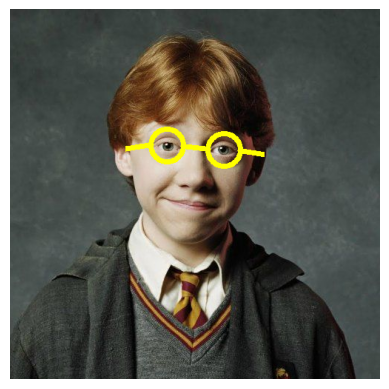

In [12]:
draw_glasses(data)